In [72]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

In [130]:
# pull dataframes from csv files
dh_data = pd.read_csv('Final_MLB_Data.csv')
dh_data = dh_data[dh_data["Qualified DH"] == "Yes"]

dh_salary = pd.read_csv('player_salaries.csv')
dh_data

,Name,Age,Team,Lg,G,PA,AB,R,H,2B,...,GDP,HBP,SH,SF,IBB,wOBA,OAA,OFF,DEF,Qualified DH
10,Jesus Aguilar,32,MIA,NL,113,456,415,37,98,18,...,8,4,0,5,1,0.295622,0.000000,0.295622,0.000000,Yes
11,Jesus Aguilar,32,BAL,AL,16,51,49,2,11,1,...,0,0,0,0,0,0.241400,0.000000,0.241400,0.000000,Yes
32,Yordan Alvarez*,25,HOU,AL,135,561,470,95,144,29,...,12,6,0,7,9,0.429964,0.000000,0.429964,0.000000,Yes
77,Josh Bell#,29,WSN,NL,103,437,375,52,113,24,...,19,5,0,6,4,0.379281,0.000000,0.379281,0.000000,Yes
78,Josh Bell#,29,SDP,NL,53,210,177,26,34,5,...,3,0,0,0,0,0.276890,0.000000,0.276890,0.000000,Yes
94,Charlie Blackmon*,35,COL,NL,135,577,530,60,140,22,...,10,8,4,3,4,0.319473,3.000000,0.319473,3.000000,Yes
189,Nelson Cruz,41,WSN,NL,124,507,448,50,105,16,...,16,4,0,3,1,0.293499,-1.000000,0.293499,-1.000000,Yes
481,Trey Mancini,30,BAL,AL,92,401,354,39,95,16,...,4,9,0,3,2,0.332607,-3.860140,0.332607,-3.860140,Yes
482,Trey Mancini,30,HOU,AL,51,186,165,17,29,7,...,8,1,0,2,0,0.275753,-2.139860,0.275753,-2.139860,Yes
495,J.D. Martinez,34,BOS,AL,139,596,533,76,146,43,...,20,5,0,5,1,0.345387,-11.000000,0.345387,-11.000000,Yes


In [132]:
def remove_non_letters(input_string):
    cleaned_string = re.sub(r'[^a-zA-ZÀ-ÿ ]', '', input_string)
    return cleaned_string

# aggregate duplicates by averaging statistics
def concat(series):
    return '/'.join(series)
aggregation_functions = {}
for column in dh_data.columns:
    if dh_data[column].dtype == 'object':
        aggregation_functions[column] = concat
    else:
        aggregation_functions[column] = "mean"

dh_data["Name"] = dh_data["Name"].apply(remove_non_letters)
dh_data = dh_data.groupby('Name', as_index=False).agg(aggregation_functions)
dh_data

,Name,Age,Team,Lg,G,PA,AB,R,H,2B,...,GDP,HBP,SH,SF,IBB,wOBA,OAA,OFF,DEF,Qualified DH
0,Andrew McCutchen,35.0,MIL,NL,134.0,580.0,515.0,66.0,122.0,25.0,...,10.0,4.0,0.0,4.0,1.0,0.311174,5.0,0.311174,5.0,Yes
1,Carlos SantanaCarlos Santana,36.0,KCR/SEA,AL/AL,65.5,253.0,215.5,26.0,43.5,9.0,...,4.5,1.0,0.0,1.0,1.0,0.310915,0.0,0.310915,0.0,Yes/Yes
2,Charlie Blackmon,35.0,COL,NL,135.0,577.0,530.0,60.0,140.0,22.0,...,10.0,8.0,4.0,3.0,4.0,0.319473,3.0,0.319473,3.0,Yes
3,JD Martinez,34.0,BOS,AL,139.0,596.0,533.0,76.0,146.0,43.0,...,20.0,5.0,0.0,5.0,1.0,0.345387,-11.0,0.345387,-11.0,Yes
4,Jesus AguilarJesus Aguilar,32.0,MIA/BAL,NL/AL,64.5,253.5,232.0,19.5,54.5,9.5,...,4.0,2.0,0.0,2.5,0.5,0.268511,0.0,0.268511,0.0,Yes/Yes
5,Josh BellJosh Bell,29.0,WSN/SDP,NL/NL,78.0,323.5,276.0,39.0,73.5,14.5,...,11.0,2.5,0.0,3.0,2.0,0.328085,0.0,0.328085,0.0,Yes/Yes
6,Luke VoitLuke Voit,31.0,SDP/WSN,NL/NL,67.5,284.0,250.0,27.5,56.5,11.0,...,4.5,3.5,0.0,3.0,0.5,0.311352,-5.0,0.311352,-5.0,Yes/Yes
7,Marcell Ozuna,31.0,ATL,NL,124.0,507.0,470.0,56.0,106.0,19.0,...,12.0,2.0,0.0,4.0,0.0,0.300237,5.0,0.300237,5.0,Yes
8,Nelson Cruz,41.0,WSN,NL,124.0,507.0,448.0,50.0,105.0,16.0,...,16.0,4.0,0.0,3.0,1.0,0.293499,-1.0,0.293499,-1.0,Yes
9,Shohei Ohtani,27.0,LAA,AL,157.0,666.0,586.0,90.0,160.0,30.0,...,6.0,5.0,0.0,3.0,14.0,0.372607,0.0,0.372607,0.0,Yes


In [133]:
# collect training data for valuable and non valueable dh
combined_df = pd.merge(dh_data,dh_salary, left_on="Name", right_on="player name", how="left")
combined_df['salary'] = combined_df['salary'].str.replace(',','').astype(float)
high_value_dh = combined_df[combined_df["salary"] >= int(combined_df["salary"].quantile(0.9))].drop("salary", axis=1)
low_value_dh = combined_df[combined_df["salary"] <= int(combined_df["salary"].quantile(0.1))].drop("salary", axis=1)
combined_df = combined_df.drop("salary", axis=1)

In [136]:
# define value and labeled set
high_value_dh = high_value_dh.assign(valuable=True)
low_value_dh = low_value_dh.assign(valuable=False)
truth_set = pd.concat([high_value_dh, low_value_dh])

In [140]:
feature_columns = ['Age', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB',
                   'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP',
                   'SH', 'SF', 'IBB', 'wOBA', 'OAA', 'OFF', 'DEF', 'pos', 'ht', 'wt', 'ba',
                   'th', 'born', 'hilvl', 'mlb years', 'stat years']
target_columns = "valuable"
categorical_features = truth_set[feature_columns].select_dtypes(include=['object']).columns

feature_columns = [x for x in feature_columns if x not in categorical_features]

X = truth_set[feature_columns]
y = truth_set[target_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)



/Users/filipcasey/School/SU2024/DATAMINING/final/Data-mining-DH/venv/lib/python3.11/site-packages/sklearn/naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/Users/filipcasey/School/SU2024/DATAMINING/final/Data-mining-DH/venv/lib/python3.11/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: divide by zero encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/filipcasey/School/SU2024/DATAMINING/final/Data-mining-DH/venv/lib/python3.11/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)


In [143]:
combined_df[feature_columns]

,Age,G,PA,AB,R,H,2B,3B,HR,RBI,...,GDP,HBP,SH,SF,IBB,wOBA,OAA,OFF,DEF,wt
0,35.0,134.0,580.0,515.0,66.0,122.0,25.0,0.0,17.0,69.0,...,10.0,4.0,0.0,4.0,1.0,0.311174,5.0,0.311174,5.0,190.0
1,36.0,65.5,253.0,215.5,26.0,43.5,9.0,0.0,9.5,30.0,...,4.5,1.0,0.0,1.0,1.0,0.310915,0.0,0.310915,0.0,NaN
2,35.0,135.0,577.0,530.0,60.0,140.0,22.0,6.0,16.0,78.0,...,10.0,8.0,4.0,3.0,4.0,0.319473,3.0,0.319473,3.0,221.0
3,34.0,139.0,596.0,533.0,76.0,146.0,43.0,1.0,16.0,62.0,...,20.0,5.0,0.0,5.0,1.0,0.345387,-11.0,0.345387,-11.0,NaN
4,32.0,64.5,253.5,232.0,19.5,54.5,9.5,0.0,8.0,25.5,...,4.0,2.0,0.0,2.5,0.5,0.268511,0.0,0.268511,0.0,NaN
5,29.0,78.0,323.5,276.0,39.0,73.5,14.5,1.5,8.5,35.5,...,11.0,2.5,0.0,3.0,2.0,0.328085,0.0,0.328085,0.0,NaN
6,31.0,67.5,284.0,250.0,27.5,56.5,11.0,0.0,11.0,34.5,...,4.5,3.5,0.0,3.0,0.5,0.311352,-5.0,0.311352,-5.0,NaN
7,31.0,124.0,507.0,470.0,56.0,106.0,19.0,0.0,23.0,56.0,...,12.0,2.0,0.0,4.0,0.0,0.300237,5.0,0.300237,5.0,225.0
8,41.0,124.0,507.0,448.0,50.0,105.0,16.0,0.0,10.0,64.0,...,16.0,4.0,0.0,3.0,1.0,0.293499,-1.0,0.293499,-1.0,230.0
9,27.0,157.0,666.0,586.0,90.0,160.0,30.0,6.0,34.0,95.0,...,6.0,5.0,0.0,3.0,14.0,0.372607,0.0,0.372607,0.0,210.0


/Users/filipcasey/School/SU2024/DATAMINING/final/Data-mining-DH/venv/lib/python3.11/site-packages/sklearn/naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/Users/filipcasey/School/SU2024/DATAMINING/final/Data-mining-DH/venv/lib/python3.11/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: divide by zero encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/filipcasey/School/SU2024/DATAMINING/final/Data-mining-DH/venv/lib/python3.11/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)


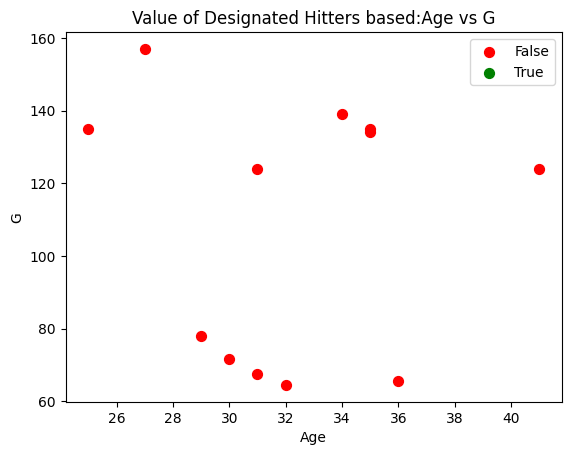

In [148]:
# plot results
x_feature = "Age"
y_feature = "G"
y_pred = gnb.predict(combined_df[feature_columns].fillna(0))

cdict = {0: 'red', 1: 'green'}

plot_df = combined_df.copy()
plot_df.insert(len(combined_df.columns), "valuable", y_pred)

for g in [False, True]:
    class_data = plot_df[plot_df["valuable"] == g]
    plt.scatter(class_data[x_feature], class_data[y_feature], c = cdict[g], label = g, s = 50)
    
plt.title("Value of Designated Hitters based:" + x_feature + " vs " + y_feature)
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.legend()
plt.show()